***OCR에서 텍스트 추출 이후, 후처리***

*어떻게 추출된 텍스트를 매핑할건지*

  + *Table Parsing Algorithm*
  

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### 1. Settings

In [2]:
import os
import sys

base_dir = "/content/gdrive/MyDrive/Workspace/Colab"
sys.path.append(base_dir)

src_dir = os.path.join(base_dir, "ocr")
%cd $src_dir

/content/gdrive/MyDrive/Workspace/Colab/ocr


In [3]:
!pip install -r requirements.txt > /dev/null

In [4]:
import getpass
from dotenv import load_dotenv

# .env 파일 로드
load_dotenv()

def get_env_variable(var_name, prompt_message) -> str:
    """
    환경 변수 가져오거나,
    없으면 사용자입력
    """
    value = os.getenv(var_name)
    if not value:
        value = getpass.getpass(prompt_message)

    return value

In [5]:
OCR_SECRET_KEY = get_env_variable("OCR_SECRET_KEY", "Enter your OCR_SECRET_KEY: ")
APIGW_URL = get_env_variable("APIGW_INVOKE_URL", "Enter your APIGW_INVOKE_URL: ")

if not OCR_SECRET_KEY:
    raise ValueError("OCR SECRET KEY not found in .env file.")
if not APIGW_URL:
    raise ValueError("APIGW INVOKE URL not found in .env file.")

### 2. OCR 수행

In [6]:
import import_ipynb
from utils.file_signature_util import FileSignatureUtil

In [7]:
from google.colab import files

# 파일 업로드
uploaded = files.upload()
for file_name, file_content in uploaded.items():
    print(f"File name: {file_name}")

image_files = list(uploaded.keys())

Saving Offline.jpg to Offline.jpg
File name: Offline.jpg


In [8]:
import time
import uuid
import json
import requests
from requests.exceptions import RequestException


def generate_request_message(file_type) -> dict:
    """
    API 요청 message 생성

    :param file_type: 파일 타입
    :return: JSON 형태의 요청 message
    """
    return {
        'version': 'V2',
        'requestId': str(uuid.uuid4()),
        'timestamp': int(round(time.time() * 1000)),
        "lang": "ko",
        'images': [
            {
                'format': file_type,
                'name': 'test'
            }
        ],
        "enableTableDetection": False
    }

In [9]:
def send_multipart_request(secret_key, api_url, image_file, request_message) -> requests.Response:
    """
    멀티파트 형식으로 OCR API 요청
    """
    try:

        image_file_type = image_file.split('.')[-1]

        with open(image_file, 'rb') as f:

            files = {
                'file': (image_file, f, f'application/{image_file_type}')
            }
            data = {
                'message': json.dumps(request_message).encode('UTF-8')
            }
            headers = {
                'X-OCR-SECRET': secret_key
            }

            response = requests.post(api_url, headers=headers, data=data, files=files)

        return response
    except FileNotFoundError:
        return None
    except RequestException as e:
        return None
    except Exception as e:
        return None

*Content-Type*
  + `application/json`
  + `multipart/form-data`

*이미지 세부정보*
  + JSON Array로 작성
  + 호출당 1개의 이미지 Array 작성 가능
  + 이미지 크기: 최대 50 MB
  + 이미지 형식: `jpg`, `jpeg`, `png`, `pdf`, `tif`, `tiff`
    - `pdf`: 최대 10 페이지 인식 가능

In [10]:
def pretty_print_json(byte_data) -> None:
    """
    pretty print
    """
    decoded_data = byte_data.decode('utf-8')
    data = json.loads(decoded_data)

    pretty_json = json.dumps(data, indent=4)
    print(pretty_json)

In [11]:
import cv2
import matplotlib.pyplot as plt

In [12]:
# OCR 후처리용
cells = []

def handle_ocr_response(response, image) -> None:
    """
    응답 처리
    """
    ocr_result = json.loads(response.text.encode('utf8'))

    all_texts = []
    annotations = []
    highlighted_image = image.copy()

    # OCR 이미지 결과 처리
    for image_result in ocr_result['images']:

        for field in image_result['fields']:
            text = field['inferText']
            confidence = field.get('inferConfidence', 'N/A')
            bounding_box = field['boundingPoly']['vertices']

            all_texts.append(f"Text: {text}, Confidence: {confidence}")

            cells.append({
                'text': text,
                'confidence': confidence,
                'bbox': (int(bounding_box[0]['x']), int(bounding_box[0]['y']), int(bounding_box[2]['x']), int(bounding_box[2]['y']))
            })

            draw_bounding_box(bounding_box, highlighted_image)

    display_results(image, highlighted_image)

    print("----------------------------------------")
    print("OCR Results:")
    for idx, text in enumerate(all_texts, start=1):
        print(f"{idx}. {text}")


def draw_bounding_box(bounding_box, image) -> None:
    """
    BBox
    """
    x_min, y_min = int(bounding_box[0]['x']), int(bounding_box[0]['y'])
    x_max, y_max = int(bounding_box[2]['x']), int(bounding_box[2]['y'])

    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)


def display_results(image, highlighted_image) -> None:
    """
    OCR 결과, 원본 이미지 출력
    OCR 인식 결과 텍스트와 highlighed bbox 까지 출력
    """
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Highlighted Image')
    axs[1].axis('off')

    plt.show()

In [13]:
def perform_ocr(image_file, file_type) -> any:
    """
    OCR 요청 수행
    """
    request_message = generate_request_message(file_type)
    return send_multipart_request(OCR_SECRET_KEY, APIGW_URL, image_file, request_message)

File Offline.jpg is a valid jpg file.


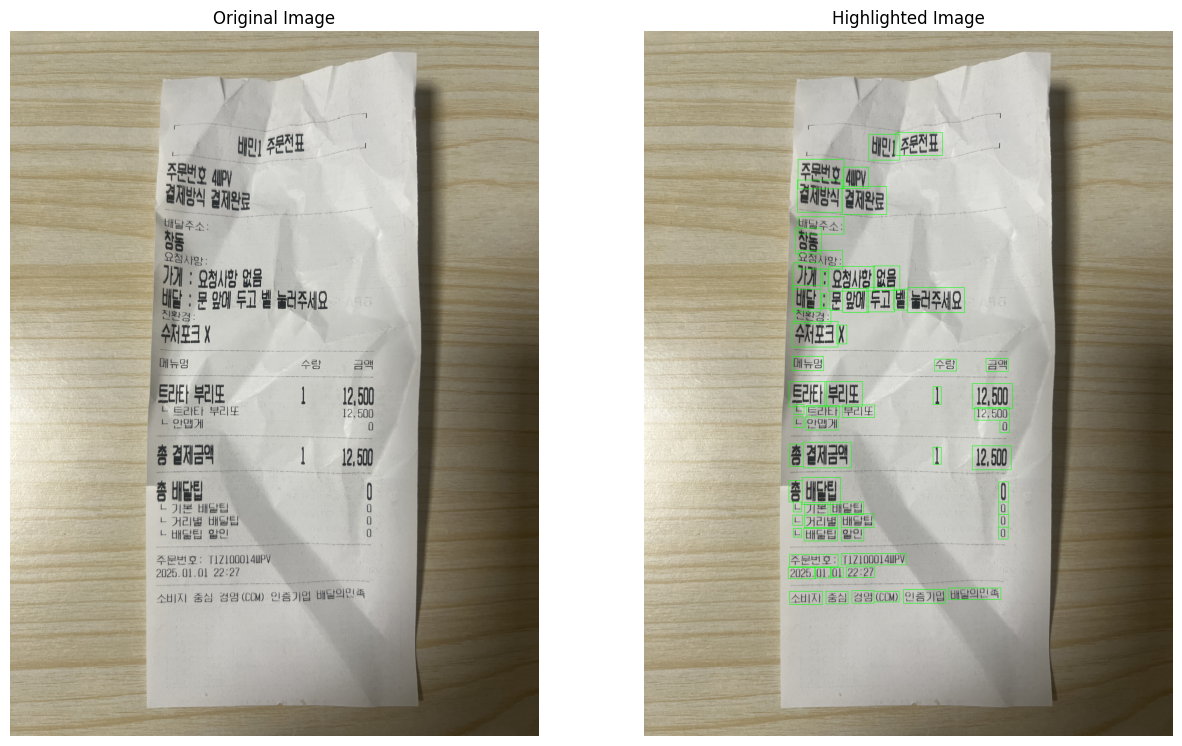

----------------------------------------
OCR Results:
1. Text: 배민1, Confidence: 0.9969
2. Text: 주문전표, Confidence: 1.0
3. Text: 주문번호, Confidence: 1.0
4. Text: 4WPV, Confidence: 0.9992
5. Text: 결제방식, Confidence: 0.9999
6. Text: 결제완료, Confidence: 0.9998
7. Text: 배달주소:, Confidence: 0.9997
8. Text: 창동, Confidence: 0.998
9. Text: 요청사항:, Confidence: 0.9981
10. Text: 가게, Confidence: 0.9999
11. Text: ··, Confidence: 0.8933
12. Text: 요청사항, Confidence: 0.9985
13. Text: 없음, Confidence: 1.0
14. Text: 배달, Confidence: 1.0
15. Text: . ., Confidence: 0.7366
16. Text: 문, Confidence: 0.9999
17. Text: 앞에, Confidence: 1.0
18. Text: 두고, Confidence: 1.0
19. Text: 벨, Confidence: 0.987
20. Text: 눌러주세요, Confidence: 0.9952
21. Text: 친환경:, Confidence: 0.9966
22. Text: 수저포크, Confidence: 0.9986
23. Text: X, Confidence: 0.5451
24. Text: 메뉴명, Confidence: 0.9999
25. Text: 수량, Confidence: 0.9999
26. Text: 금액, Confidence: 1.0
27. Text: 트라타, Confidence: 0.9996
28. Text: 부리또, Confidence: 0.9986
29. Text: 1, Confidence: 1.

In [14]:
# 파일별
for image_file in image_files:

    try:
        # 파일 읽기
        image = cv2.imread(image_file)
        if image is None:
            continue

        # 매직 넘버 검증
        file_type = FileSignatureUtil.get_file_type(image_file)
        if not file_type:
            continue

        print(f"File {image_file} is a valid {file_type} file.")

        # OCR 수행
        response = perform_ocr(image_file, file_type)

        if response.status_code == 200:
            # print(pretty_print_json(response.text.encode('utf8')))
            handle_ocr_response(response, image)
        else:
            print(response.status_code)
            print(response.text)
            continue
    except ValueError as e:
        print(e)

### 3. OCR 후처리 적용


*1단계*  

+ *각 셀의 바운딩박스에서 왼쪽 상단의 점을 가져옴*  
+ *이 점들을 각 셀을 대표하는 위치로 가정*  

*2단계*  

+ *행을 대표하는 수식으로 $y=a x+b$ 을 사용할 것이기 때문에 $a$ 가 infinity가 되지 않도록 처리*  
+ *열(column)을 대표하는 수식은 a 가 infinity가 될 수 있어 y 가 infinity가 되는 것을 사전에 방지*  
+ *열을 찾는 경우에는 모든 셀의 좌표를 $90^{\circ}$ 회전하여 행을 찾는 알고리즘을 사용*

*3단계*  

+ *셀 집합 $\left(P \supset p_1, p_2, p_3, \cdots, p_n\right)$ 에서 원점에서 제일 가까운 셀 $\left(p_{\text {criterion }}\right)$ 을 찾음*  
+ *원점과 셀의 거리를 계산할 때, 아래 수식과 같이 유클리디언 제곱 거리 수식 에서 y 축에대한 거리를 늘릴 수 있도록 상수를 곱하여 계산*  
+ *거리는 순서를 세우는데 사용되므로 계산 효율을 얻기 위해 유클리디언 거리에서처럼 제곱근은 사용하지 않았음*
  + *대신 CSED: Custom Squared Euclidean Distance를 사용*  
+ *x축에 비해 y축에 대해 더 큰 가중치를 부여하여, 수직 방향으로 가까운 셀들을 우선적으로 고려*

$$
d_{\operatorname{CSED}}^2\left(\left(x_1, y_1\right),\left(x_2, y_2\right)\right)=\left(0.1 *\left(x_1-x_2\right)\right)^2+\left(8 *\left(y_1-y_2\right)\right)^2
$$
  
*4단계*  

+ *$\mathrm{P}_{\text {criterion }}$ 를 기준으로 같은 방향으로 가까운 두 셀 $\left(\mathrm{P}_1, \mathrm{P}_2\right)$ 을 찾음*  
+ *모든 셀 을 순회하진 않으며, N 개의 셀을 최대로 두고 확인*  
+ *CSED를 사용하여, y축 방향으로 가까운 셀들을 먼저 찾음*  
+ *$y$축에 대한 가중치를 늘려주었기 때문에, 양옆에 가까운 셀들을 먼저 탐색*  
+ *$\mathrm{P}_{\text {criterion }}$ 와 $\mathrm{p}_1, \mathrm{p}_2$ 를 찾으면 하나의 클러스터가 만들수 있음*  

*5단계*  

+ *하나의 클러스터는 $\mathrm{P}_{\text {criterion }}$ 를 시작점으로 하여 나머지 셀들을 이어 만든 각각의 직선이 존재*  
+ *각의 직선을 평균내어 현재 클러스터를 대표하는 직선을 만듦*  
+ *대표 직선과의 거리가 멀지 않은 지점에 후보 셀을 확인*  
+ *후보 셀이 대표직선과 일정 범위 이내에 위치한다면 후보셀을 클러스터에 넣고, 대표직선을 업데이트함*

*다시 3단계*

+ *5단계까지 사용된 모든 셀들은 $\mathrm{P}$에서 제거하고, 클러스터내에 셀들의 순서를 정리하고, 다시 3단계로 돌아가 $\mathrm{P}$가 빈 집합이 될 때까지 반복*  


In [15]:
import numpy as np

In [16]:
# cells

In [17]:
def CSED(x1, y1, x2, y2) -> float:
    """
    CSED (Custom Squared Euclidean Distance)
    두 점 사이의 CSED 계산 (x1, y1)과 (x2, y2) 간의 거리
    """
    return (0.1 * (x1 - x2))**2 + (8 * (y1 - y2))**2


def find_closest_cell(cells) -> dict:
    """
    CSED 기준으로 원점에서 가장 가까운 셀 찾기
    """
    origin = (0, 0)  # 원점
    min_csed = float('inf')
    closest_cell = None

    for cell in cells:
        x1, y1, x2, y2 = cell['bbox']
        csed = CSED(x1, y1, origin[0], origin[1])

        if csed < min_csed:
            min_csed = csed
            closest_cell = cell

    return closest_cell

In [18]:
def find_p1_p2(cells, p_criterion, N=2) -> list:
    """
    기준 셀을 기준으로 가까운 두 셀(p1, p2) 찾기
    """
    x1, y1, x2, y2 = p_criterion['bbox']

    # P_criterion과 다른 셀들 간의 CSED 계산
    distances = []
    for cell in cells:
        if cell != p_criterion:  # 기준 셀 제외
            x1_cell, y1_cell, x2_cell, y2_cell = cell['bbox']
            dist = CSED(x1, y1, x1_cell, y1_cell)
            distances.append((dist, cell))

    # y축 방향으로 가까운 셀들, 우선 정렬
    distances.sort(key=lambda x: x[0])

    # N개의 가까운 셀을 선택 (최대 N개)
    closest_cells = [cell for _, cell in distances[:N]]

    return closest_cells

In [19]:
def fit_line(points) -> tuple:
    """
    주어진 점들로부터 직선의 파라미터(a, b) 계산
    """
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]

    # 수직선에 가까운 경우 처리
    if max(x_coords) - min(x_coords) < 1e-6:
        return float('inf'), np.mean(x_coords)

    # 최소제곱법으로 직선 피팅
    A = np.vstack([x_coords, np.ones(len(x_coords))]).T
    a, b = np.linalg.lstsq(A, y_coords, rcond=None)[0]

    return a, b


def calculate_line_distance(point, line_params) -> float:
    """
    점과 직선 사이의 거리 계산

    point: (x, y)
    line_params: (a, b) where y = ax + b
    """
    x, y = point
    a, b = line_params

    if a == float('inf'):  # 수직선의 경우
        return abs(x - b)

    return abs(y - (a * x + b)) / np.sqrt(1 + a**2)

In [23]:
def check_line_validity(p_criterion, p_candidate, y_threshold=50) -> bool:
    """
    p_criterion과 후보 점이 유효한 직선을 형성하는지 확인
    """
    x1, y1 = p_criterion['bbox'][:2]
    x2, y2 = p_candidate['bbox'][:2]

    # y축 기준으로 거리 차이가 너무 큰 경우 제외
    if abs(y2 - y1) > y_threshold:
        return False

    return True


def form_cluster(p_criterion, candidates, y_threshold=50) -> list:
    """
    p_criterion을 기준으로 p1, p2를 추가하여 클러스터를 형성
    """
    cluster = [p_criterion]
    for candidate in candidates:
        if check_line_validity(p_criterion, candidate, y_threshold):
            cluster.append(candidate)

    # x 좌표 기준으로 정렬
    cluster.sort(key=lambda cell: cell['bbox'][0])
    return cluster


def parse_table(cells) -> list:
    """
    전체 테이블 파싱 실행
    """
    remaining_cells = cells.copy()
    clusters = []

    while remaining_cells:
        # 1. p_criterion 선택
        p_criterion = remaining_cells.pop(0)

        # 2. p_criterion과 가까운 p1, p2 선택
        p1_p2 = [
            cell for cell in remaining_cells
            if check_line_validity(p_criterion, cell)
        ][:6]  # 가장 가까운 6개만 선택

        # 3. 클러스터 생성
        cluster = form_cluster(p_criterion, p1_p2)
        clusters.append(cluster)

        # 4. 클러스터에 포함되면, 제거
        for cell in cluster:
            if cell in remaining_cells:
                remaining_cells.remove(cell)

    return clusters

In [24]:
# 셀 갯수
print(len(cells))

68


In [25]:
clusters = parse_table(cells)

# 결과 출력
for i, cluster in enumerate(clusters):
    print(f"\n클러스터 {i + 1}:")
    for cell in cluster:
        print(f"텍스트: {cell['text']}, 좌표: {cell['bbox']}")


클러스터 1:
텍스트: 배민1, 좌표: (1285, 590, 1462, 738)
텍스트: 주문전표, 좌표: (1439, 581, 1706, 711)

클러스터 2:
텍스트: 주문번호, 좌표: (880, 733, 1143, 902)
텍스트: 4WPV, 좌표: (1138, 778, 1282, 900)

클러스터 3:
텍스트: 결제방식, 좌표: (876, 852, 1131, 1036)
텍스트: 결제완료, 좌표: (1133, 888, 1387, 1049)

클러스터 4:
텍스트: 배달주소:, 좌표: (880, 1062, 1143, 1161)

클러스터 5:
텍스트: 창동, 좌표: (864, 1127, 1015, 1274)

클러스터 6:
텍스트: 요청사항:, 좌표: (881, 1254, 1135, 1361)

클러스터 7:
텍스트: 가게, 좌표: (853, 1325, 1008, 1476)
텍스트: ··, 좌표: (1019, 1375, 1051, 1458)
텍스트: 요청사항, 좌표: (1055, 1346, 1318, 1487)
텍스트: 없음, 좌표: (1310, 1343, 1462, 1483)

클러스터 8:
텍스트: 배달, 좌표: (850, 1454, 1008, 1606)
텍스트: . ., 좌표: (1015, 1501, 1040, 1580)
텍스트: 문, 좌표: (1062, 1487, 1134, 1598)
텍스트: 앞에, 좌표: (1134, 1472, 1282, 1609)
텍스트: 두고, 좌표: (1274, 1465, 1433, 1606)
텍스트: 벨, 좌표: (1426, 1476, 1505, 1595)
텍스트: 눌러주세요, 좌표: (1506, 1467, 1832, 1610)

클러스터 9:
텍스트: 친환경:, 좌표: (865, 1588, 1068, 1674)

클러스터 10:
텍스트: 수저포크, 좌표: (846, 1660, 1109, 1807)
텍스트: X, 좌표: (1102, 1681, 1159, 1789)

클러스터 11:
텍스트: 메뉴명, 좌표: (847, 

### 4. 후처리 결과 확인 (클러스터끼리 같은 색상으로 표시)

* 원래는 p1,p2 2개가 디폴트인데, 영수증 데이터를 보고 6개로 늘림
  + 즉, p_criterion에 대해 주변 6개까지의 데이터를 같은 클러스터에 넣을건지 말건지 고려하겠다는 의미

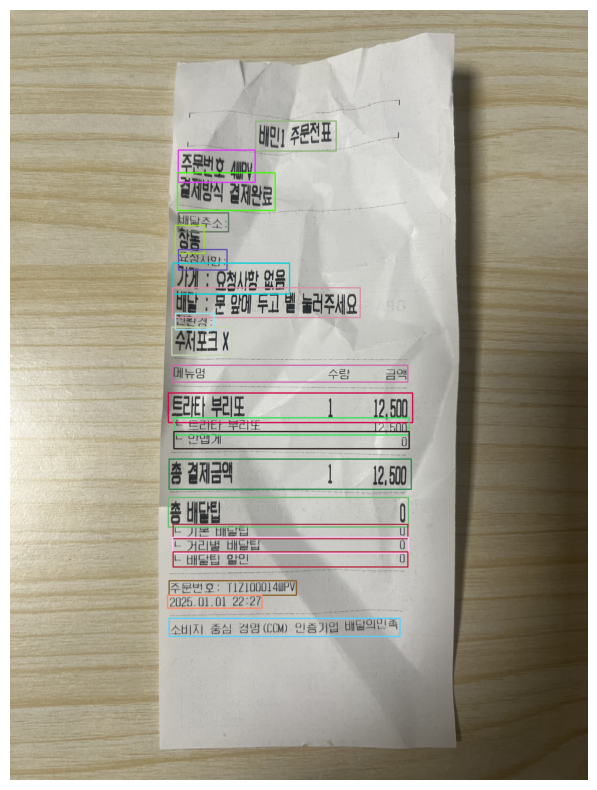

In [27]:
from google.colab.patches import cv2_imshow


image = cv2.imread(image_file)

def generate_colors(num_clusters) -> list:
    """
    클러스터별, 색상 생성
    """
    colors = []
    for i in range(num_clusters):
        colors.append((np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256)))

    return colors


colors = generate_colors(len(clusters))

# 클러스터별, bbox 그리기
for cluster_idx, cluster in enumerate(clusters):
    min_x = min(cell['bbox'][0] for cell in cluster)
    min_y = min(cell['bbox'][1] for cell in cluster)
    max_x = max(cell['bbox'][2] for cell in cluster)
    max_y = max(cell['bbox'][3] for cell in cluster)

    color = colors[cluster_idx]

    cv2.rectangle(image, (min_x, min_y), (max_x, max_y), color, 5)


# 이미지 출력
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()